### Import libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight

from skimage.io import imread
from skimage.transform import resize
import numpy as np
import math


import numpy as np
from tsaug.visualization import plot
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse, AddNoise, Dropout


tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


### Set seed for reproducibility

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Load dataset and compute class weights

In [3]:
data = np.load('training_dataset/x_train.npy')
labels = np.load('training_dataset/y_train.npy')

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(labels),
                                        y = labels                                                    
                                    )
                                
class_weights = dict(zip(np.unique(labels), class_weights))
class_weights

{0: 5.953431372549019,
 1: 1.6456639566395663,
 2: 0.7496913580246913,
 3: 0.5312773403324584,
 4: 3.264784946236559,
 5: 1.3229847494553377,
 6: 0.6466986155484558,
 7: 2.9767156862745097,
 8: 1.6868055555555554,
 9: 0.2605105105105105,
 10: 2.628787878787879,
 11: 3.968954248366013}

In [4]:
columns_y = ['Wish','Another','Comfortably','Money','Breathe','Time','Brain','Echoes','Wearing','Sorrow','Hey','Shine']
columns_x = ['Variable_1','Variable_2','Variable_3','Variable_4','Variable_5','Variable_6']

sequences_per_label = [34,123,270,381,62,153,313,68,120,777,77,51]

In [5]:
test_set = False

if test_set:
    X_train, X_valid, y_train, y_valid = train_test_split(data, labels, test_size=0.20, shuffle = True)
    print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
    X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.20, shuffle = True)
    print(X_valid.shape, X_test.shape, y_valid.shape, y_test.shape)
else:
    X_train, X_valid, y_train, y_valid = train_test_split(data, labels, test_size=0.10, shuffle = True)
    print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(2186, 36, 6) (243, 36, 6) (2186,) (243,)


In [6]:
y_train = tfk.utils.to_categorical(y_train)
y_valid = tfk.utils.to_categorical(y_valid)
if test_set:
    y_test = tfk.utils.to_categorical(y_test)

input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 200

print(input_shape)
print(classes)

(36, 6)
12


# Data augmentation

In [7]:
def shift_sequence(data, num_features = 6):
    sample = np.copy(data)

    # Randomly select a time point from the sample
    time_index = np.random.randint(len(data))
    time_point = sample[time_index]

    # Shift the sample by the randomly selected time point
    shifted_sample = np.roll(sample, time_index, axis=0)

    # Replace a randomly selected feature with the randomly selected time point
    feature_index = np.random.randint(num_features)
    shifted_sample[0, feature_index:] = time_point[feature_index:]

    # Store the augmented sample in the augmented data array
    aug_data = np.copy(shifted_sample)
    return aug_data

In [8]:
my_augmenter = (
    AddNoise(scale=(0.01, 0.08)) @ 0.5  # with 50% probability, add random noise up to 1% - 8%
)

def apply_aug(elem):
    elem = shift_sequence(elem)
    elem = my_augmenter.augment(elem)
    return elem

(<Figure size 1600x200 with 1 Axes>, <AxesSubplot: >)

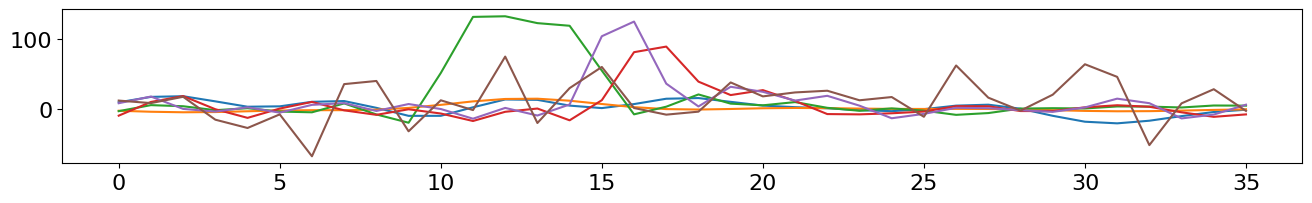

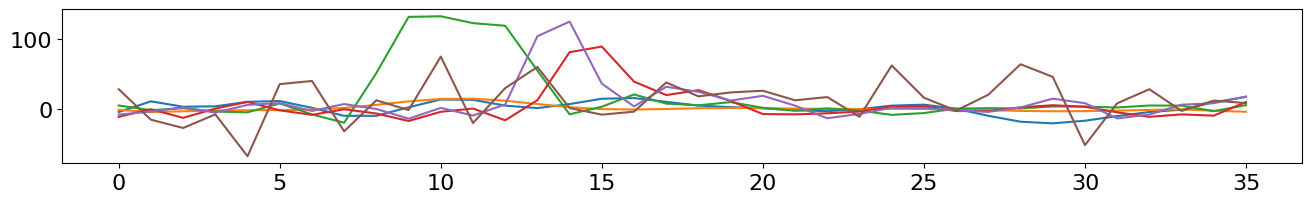

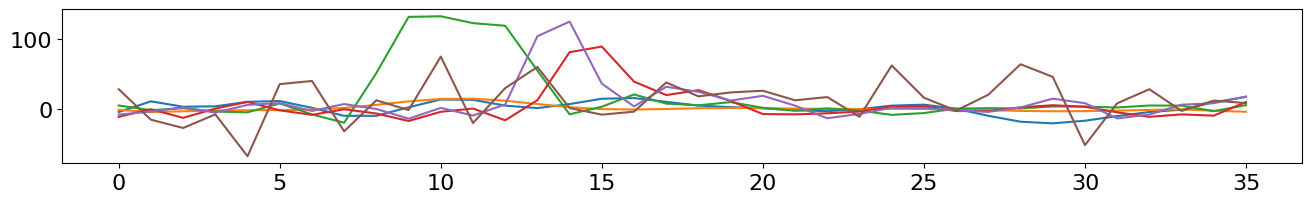

In [9]:
# Plot one original sequence
series = np.copy(X_train[2])
dummy_batch=np.expand_dims(series, axis=0)
plot(dummy_batch)

# Plot the same sequence shifted
series_shifted = np.copy(shift_sequence(X_train[2]))
dummy_batch_shifted=np.expand_dims(series_shifted, axis=0)
plot(dummy_batch_shifted)

# Plot the same sequence with noise injection
X_aug = my_augmenter.augment(dummy_batch_shifted)
plot(X_aug)

In [10]:
# AugSequencesGenerator is a keras Sequence class that automatically generate batches with defined length

# Here, `x_set` is list of path to the images
# and `y_set` are the associated classes.

class AugSequencesGenerator(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]

        # For each elem in the batch augmentation is applied
        return np.array([apply_aug(elem) for elem in batch_x]), np.array(batch_y)

# Instatiate a generator
generator = AugSequencesGenerator(x_set=X_train, y_set=y_train, batch_size=128)

# Model

In [11]:
def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(128, return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(128)(lstm)
    dropout = tfkl.Dropout(.5, seed=seed)(lstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [12]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128))(bilstm)
    dropout = tfkl.Dropout(.5, seed=seed)(bilstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [13]:
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.5, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [14]:
def build_GRU_model(input_shape, classes):
    # Build the model
    model = tf.keras.Sequential()

    # Feature extractor
    # Add a first GRU layer with 256 units and return sequences
    model.add(tf.keras.layers.GRU(256, input_shape=input_shape, return_sequences=True))
    # Add a dropout layer to prevent overfitting
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.GRU(128))

    # Add a dense layer with 64 units and ReLU activation
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))

    # Add a final dense layer with the number of classes and softmax activation
    model.add(tf.keras.layers.Dense(classes, activation='softmax'))

    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')


    return model

In [15]:
model = build_BiLSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 36, 256)          138240    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 12)                1548  

### Train

In [16]:
# Utility function to create folders and callbacks for training
from tensorflow.keras.callbacks import ModelCheckpoint

def create_callbacks() :
    callbacks = []

    # Early Stopping -----------------------------------------------------
    es_callback = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)
    callbacks.append(es_callback)
    
    # Checkpointer -------------------------------------------------------
    checkpointer = ModelCheckpoint(filepath='./checkpoint/BiLSTM.h5', verbose=1, 
                                    save_best_only=True, monitor = "val_accuracy", mode = "auto",)
    callbacks.append(checkpointer)
    
    # Learning Rate Scheduler --------------------------------------------
    LRS_callback = tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    callbacks.append(LRS_callback)
    
    return callbacks

In [17]:
# Train the model
history = model.fit(
    x = generator,
    epochs = epochs,
    validation_data=(X_valid, y_valid),
    class_weight = class_weights,
    callbacks = create_callbacks()
).history

Epoch 1/200
18/18 [==============================] - ETA: 0s - loss: 2.2887 - accuracy: 0.1331
Epoch 1: val_accuracy improved from -inf to 0.25514, saving model to ./checkpoint\BiLSTM.h5
18/18 [==============================] - 32s 305ms/step - loss: 2.2887 - accuracy: 0.1331 - val_loss: 2.0139 - val_accuracy: 0.2551 - lr: 0.0010
Epoch 2/200
17/18 [===========================>..] - ETA: 0s - loss: 1.8227 - accuracy: 0.2610
Epoch 2: val_accuracy improved from 0.25514 to 0.36626, saving model to ./checkpoint\BiLSTM.h5
18/18 [==============================] - 3s 154ms/step - loss: 1.8216 - accuracy: 0.2612 - val_loss: 1.6241 - val_accuracy: 0.3663 - lr: 0.0010
Epoch 3/200
18/18 [==============================] - ETA: 0s - loss: 1.5836 - accuracy: 0.2987
Epoch 3: val_accuracy did not improve from 0.36626
18/18 [==============================] - 3s 147ms/step - loss: 1.5836 - accuracy: 0.2987 - val_loss: 1.4978 - val_accuracy: 0.3580 - lr: 0.0010
Epoch 4/200
18/18 [=========================

### Plots

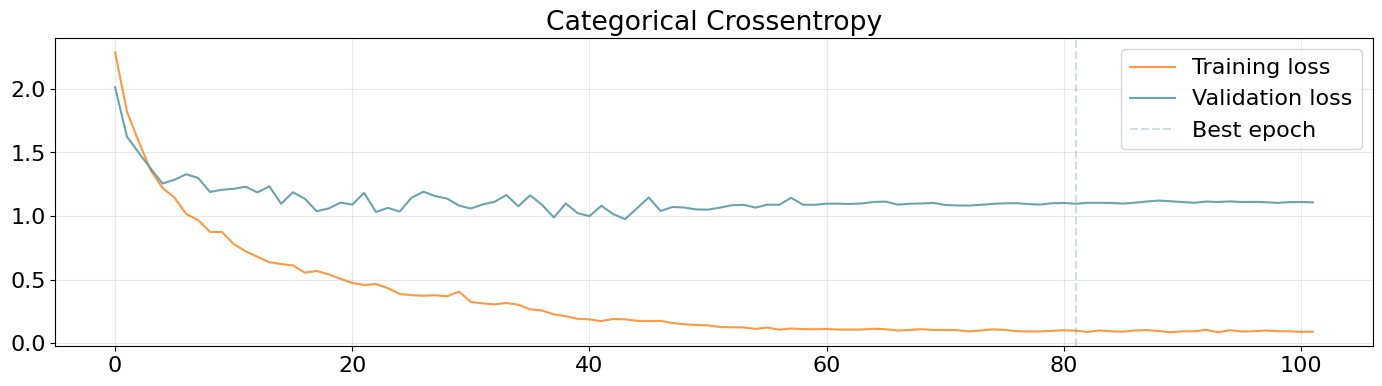

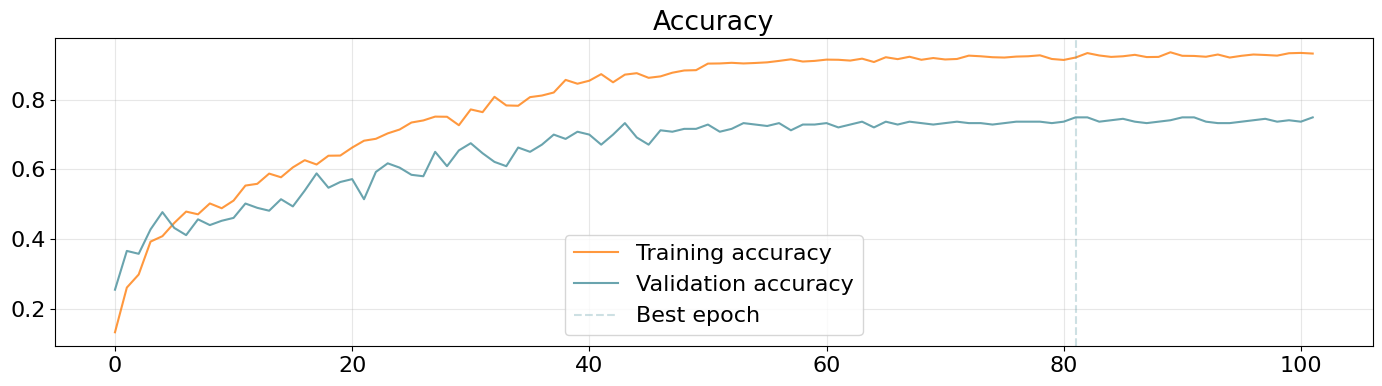

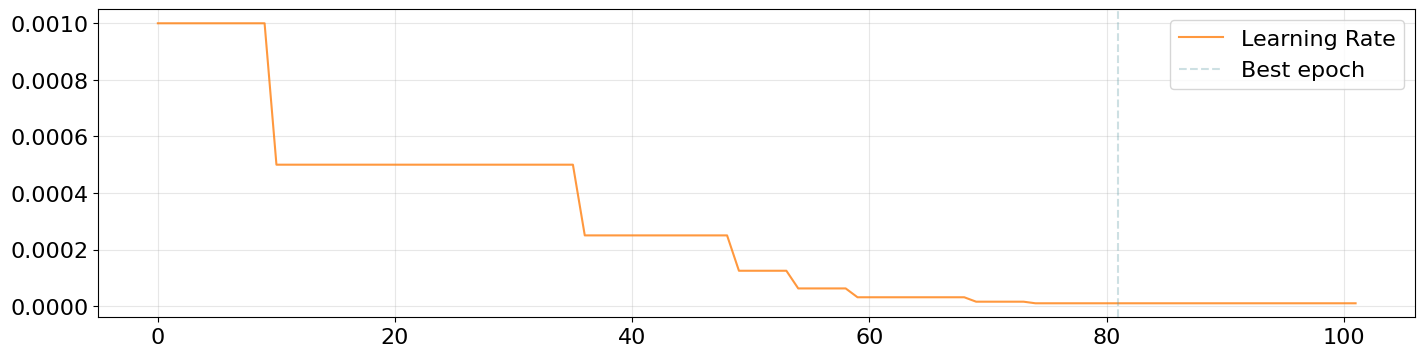

In [18]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()